In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import math
import re

In [3]:
def readLog(filename):
    with open(filename) as f:
        lines = f.readlines()
    f.close()
    len(lines)
    start_flag = 0
    stop_flag = 0
    newlines = []
    for line in lines:
    
        if start_flag == 1:
            newlines.append(line)
        else:
            # print(line)
            pass
        if stop_flag == 1:
            break
    
        if start_flag == 0:
            if line=='START READOUT\n':
                stop_flag = 0
                start_flag = 1
        else:
            if line=='STOP READOUT\n':
                start_flag = 0
                stop_flag = 1
    
    # delete the last line
    newlines = newlines[0:-2]
    len(newlines)

    df = pd.DataFrame()
    cnt=0
    #for line in newlines:
    for j in range(len(newlines)):
        line = newlines[j]
        try:
            bit32 = int(line.replace('\n', '').replace('0X', ''), 16)
        except ValueError:
            print('ValueError')
            print(j, line)
            continue
        
        header2bit = bit32>>30
        if header2bit != 2:
            print('Header 2 bits are {:d}. Broken data is detected.'.format(header2bit))
            continue
            
        n=(bit32 & 0x3FFFFFFF) >> 28
    
        if n == 0 and cnt==0:
            ch_n0  = (bit32 & 0x0FFFFFFF) >> 24
            adc = (bit32 & 0x00FFFFFF) >> 12
            tdc_65to54 = (bit32 & 0x00000FFF)
            cnt = 1
        if n == 1 and cnt==1:
            ch_n1  = (bit32 & 0x0FFFFFFF) >> 24
            tdc_53to30 = (bit32 & 0x00FFFFFF)
            cnt = 2
        if n == 2 and cnt==2:
            ch_n2  = (bit32 & 0x0FFFFFFF) >> 24
            tdc_29to6 = (bit32 & 0x00FFFFFF)
            cnt = 3
        if n == 3 and cnt==3:
            ch_n3 = (bit32 & 0x0FFFFFFF) >> 24
            tdc_5to0 = (bit32 & 0x00FFFFFF) >> 18
            n_trg_duplicated = (bit32 & 0x0003FFFF) >> 14
            tdc_data_valid = (bit32 & 0x00003FFF) >> 13
            cnt = 0
            if ch_n0 == ch_n1 == ch_n2 == ch_n3: 
                ch = ch_n0
            else:
                print('ch_nx are not the same. Broken data is detected.')
                continue
    
            tdc = (tdc_65to54 << 54) + (tdc_53to30 << 30) + (tdc_29to6 << 6) + tdc_5to0
            tdc_65to50 = tdc >> 50
            tdc_49to0  = tdc & 0x3FFFFFFFFFFFF
    
            t_rising  = 2.*(tdc_49to0 >> 3)  + 0.25*(tdc_49to0 & 0x7) #[ns]
            t_falling = 2.*(tdc_65to50 >> 3) + 0.25*(tdc_65to50 & 0x7) #[ns]
            t_rising_mod = 2.*((tdc_49to0 >> 3) & 0xFFF) + 0.25*(tdc_49to0 & 0x7)
            delt = t_falling - ( 2.*((tdc_49to0 >> 3) & 0xFFF) + 0.25*(tdc_49to0 & 0x7))
    
            if delt < 0.:
                delt += 4096 #2**12
                
            if delt > 8191:
                delt = delt - 8192
            
            df_tmp = pd.DataFrame({'Ch': [ch], 'ADC': [adc], 'Tr [ns]': [t_rising], 'Tr mod': [t_rising_mod], 'Tf [ns]': [t_falling], 'delT [ns]': [delt], 'TDC data valid': [tdc_data_valid], 'Duplicated TRG':[n_trg_duplicated]})
            df = pd.concat([df, df_tmp], axis=0)
        
    df.reset_index(drop=True, inplace = True)


    
    return df

In [4]:
#directory = r"data"

#directory = r"test3data"

#directory = r"2.28vdata"

directory = r"v1.3board_logs/Ch3_w_button/"

dfs = {}

def gaussFunc(x,A,mu,sig):
    y = A * np.exp(-0.5*((x-mu)/sig)**2) 
    return y

# Iterate over files in directory
for name in os.listdir(directory):
    if name[0] != ".":
        #dfName = name[6:-15]
        #dfName = name[6:-15] # test3data format
        dfName = re.search(r'(\d+[m][v])',name).group(1)
        print(dfName)
        #df = readLog("data/{}".format(name))
        #df = readLog("2.28vdata/{}".format(name))
        df = readLog("{0}/{1}".format(directory,name))
        dfs[dfName] = df
dfs = dict(sorted(dfs.items(), key=lambda x: float(re.sub(r'[m][v]', '', x[0]))))

700mv
6mv
900mv
600mv
1400mv
ch_nx are not the same. Broken data is detected.
40mv
800mv
30mv
450mv
500mv
80mv
10mv
60mv
400mv
1000mv
ch_nx are not the same. Broken data is detected.
200mv
ch_nx are not the same. Broken data is detected.
150mv
1100mv
ch_nx are not the same. Broken data is detected.
300mv
50mv
1200mv
20mv
250mv
ch_nx are not the same. Broken data is detected.
8mv
100mv
1300mv
350mv


In [5]:


dfs["1000mv"].head(60)


,Ch,ADC,Tr [ns],Tr mod,Tf [ns],delT [ns],TDC data valid,Duplicated TRG
0,1,0,0.000000e+00,0.00,0.00,0.00,0,0
1,2,251,8.146343e+09,5541.50,5544.00,2.50,1,0
2,2,2654,1.301916e+06,7579.75,7584.50,4.75,1,0
3,2,255,1.944103e+09,1843.75,10039.25,3.50,1,0
4,2,258,1.944260e+09,3301.00,3303.75,2.75,1,0
5,2,249,1.944275e+09,1881.00,1885.25,4.25,1,0
6,2,251,1.944358e+09,2894.25,2898.00,3.75,1,0
7,2,249,1.944381e+09,1203.50,9399.00,3.50,1,0
8,2,258,1.944461e+09,8.75,8203.00,2.25,1,0
9,2,254,1.944485e+09,7090.00,15286.00,4.00,1,0


In [6]:
# extra cuts

# data cuts 16/04
'''
dfs["40mv"] = dfs["40mv"][dfs["40mv"]["ADC"] > 350]
dfs["60mv"] = dfs["60mv"][dfs["60mv"]["ADC"] > 400]
dfs["100mv"] = dfs["100mv"][dfs["100mv"]["ADC"] > 480]
dfs["200mv"] = dfs["200mv"][dfs["200mv"]["ADC"] > 320]
dfs["300mv"] = dfs["300mv"][dfs["300mv"]["ADC"] > 300]
dfs["300mv"] = dfs["300mv"][dfs["300mv"]["ADC"] < 3000]
dfs["400mv"] = dfs["400mv"][dfs["400mv"]["ADC"] > 450]
dfs["500mv"] = dfs["500mv"][dfs["500mv"]["ADC"] >  400]
dfs["600mv"] = dfs["600mv"][dfs["600mv"]["ADC"] >  600]
dfs["800mv"] = dfs["800mv"][dfs["800mv"]["ADC"] >  300]
dfs["1000mv"] = dfs["1000mv"][dfs["1000mv"]["ADC"] >  500]
dfs["1200mv"] = dfs["1200mv"][dfs["1200mv"]["ADC"] >  1000]
dfs["1500mv"] = dfs["1500mv"][dfs["1500mv"]["ADC"] >  1000]
dfs["2000mv"] = dfs["2000mv"][dfs["2000mv"]["ADC"] >  1000]
'''

# test3data cuts 17/04
'''
dfs["40mv"] = dfs["40mv"][dfs["40mv"]["ADC"] > 350]
dfs["60mv"] = dfs["60mv"][dfs["60mv"]["ADC"] > 400]
dfs["80mv"] = dfs["80mv"][dfs["80mv"]["ADC"] > 480]
dfs["100mv"] = dfs["100mv"][dfs["100mv"]["ADC"] > 480]
'''
#2.28V dac cuts 19/04
'''
dfs["100mv"] = dfs["100mv"][dfs["100mv"]["ADC"] >  300]
dfs["200mv"] = dfs["200mv"][dfs["200mv"]["ADC"] >  300]
dfs["400mv"] = dfs["400mv"][dfs["400mv"]["ADC"] > 600]
dfs["500mv"] = dfs["500mv"][dfs["500mv"]["ADC"] > 500]
dfs["600mv"] = dfs["600mv"][dfs["600mv"]["ADC"] > 1000]
dfs["800mv"] = dfs["800mv"][dfs["800mv"]["ADC"] > 1600]
dfs["1000mv"] = dfs["1000mv"][dfs["1000mv"]["ADC"] >  500]
dfs["1200mv"] = dfs["1200mv"][dfs["1200mv"]["ADC"] >  1000]
dfs["1400mv"] = dfs["1400mv"][dfs["1400mv"]["ADC"] >  1000]
'''



'\ndfs["100mv"] = dfs["100mv"][dfs["100mv"]["ADC"] >  300]\ndfs["200mv"] = dfs["200mv"][dfs["200mv"]["ADC"] >  300]\ndfs["400mv"] = dfs["400mv"][dfs["400mv"]["ADC"] > 600]\ndfs["500mv"] = dfs["500mv"][dfs["500mv"]["ADC"] > 500]\ndfs["600mv"] = dfs["600mv"][dfs["600mv"]["ADC"] > 1000]\ndfs["800mv"] = dfs["800mv"][dfs["800mv"]["ADC"] > 1600]\ndfs["1000mv"] = dfs["1000mv"][dfs["1000mv"]["ADC"] >  500]\ndfs["1200mv"] = dfs["1200mv"][dfs["1200mv"]["ADC"] >  1000]\ndfs["1400mv"] = dfs["1400mv"][dfs["1400mv"]["ADC"] >  1000]\n'

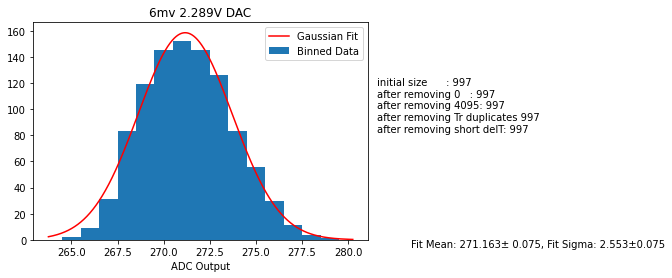

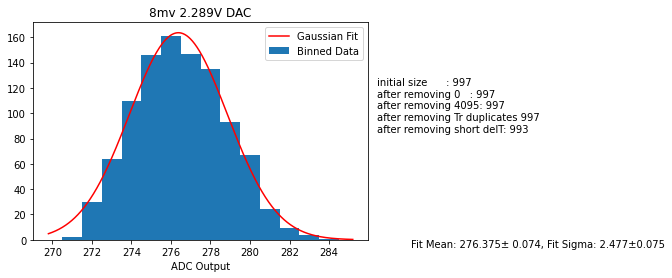

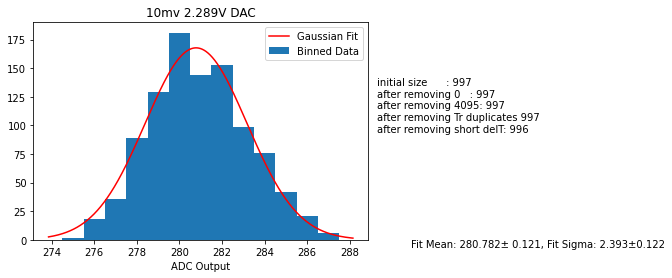

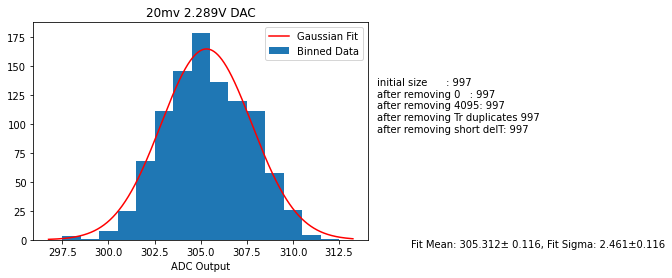

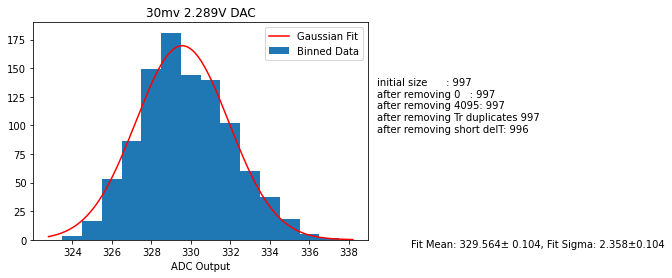

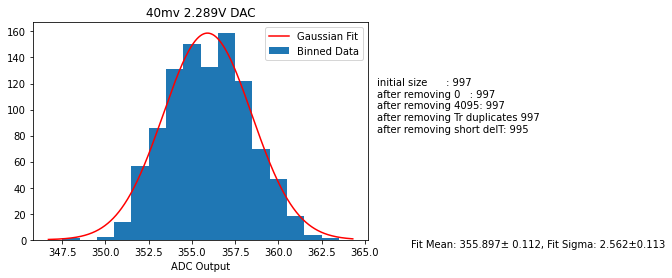

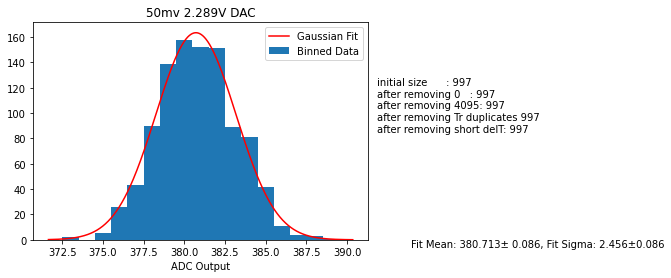

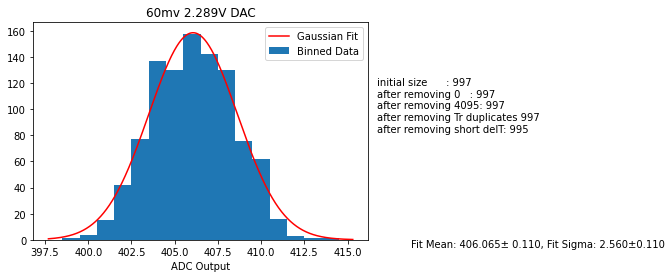

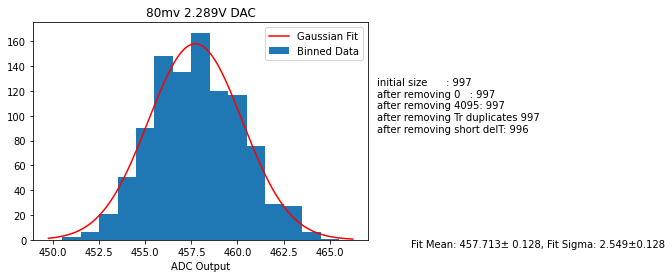

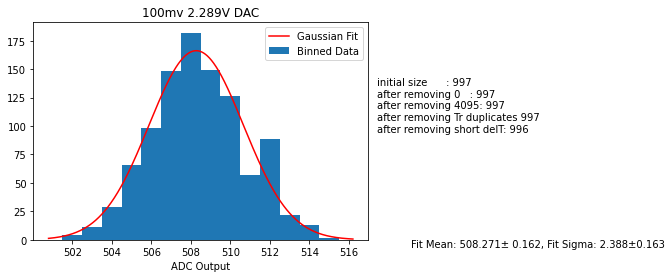

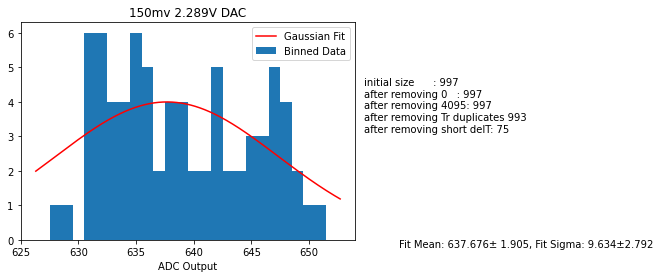

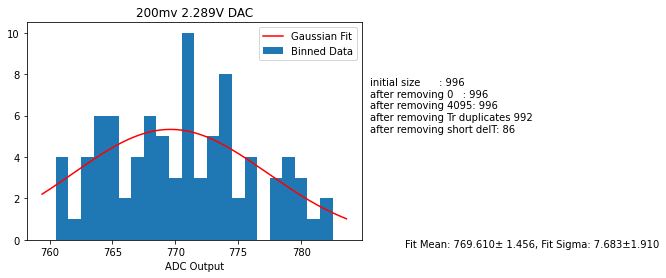

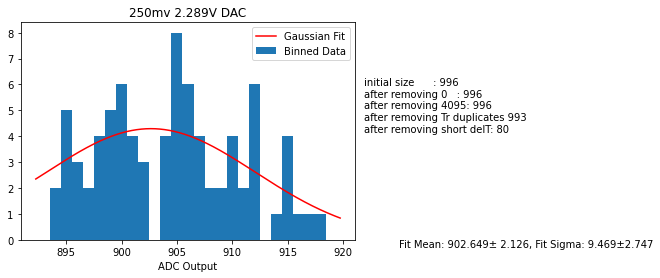

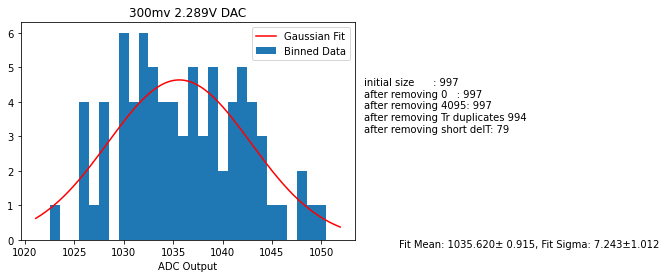

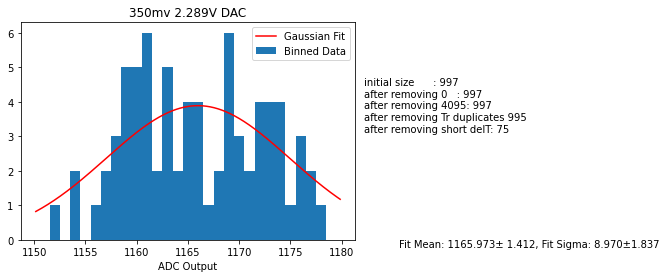

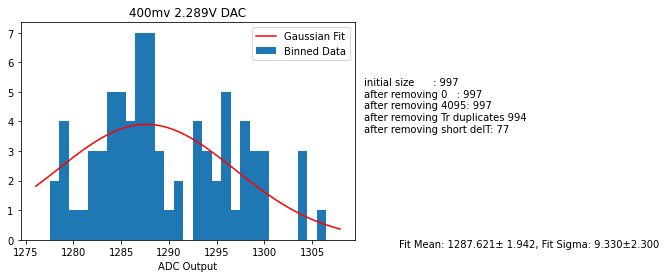

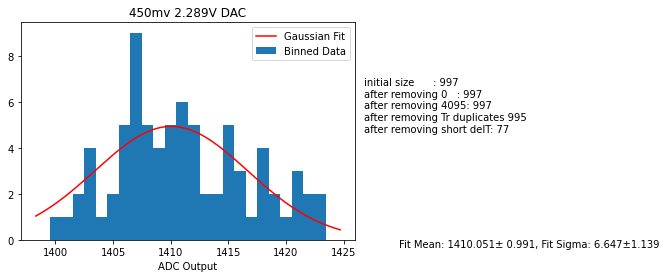

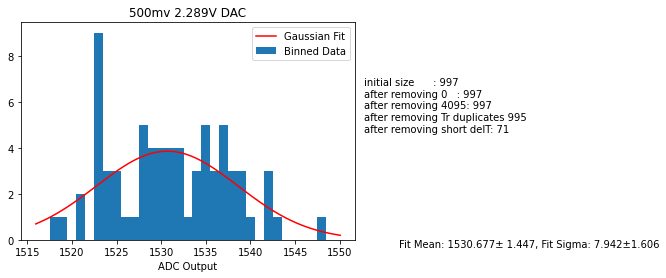

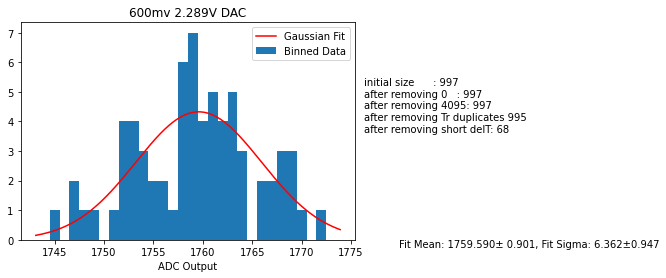

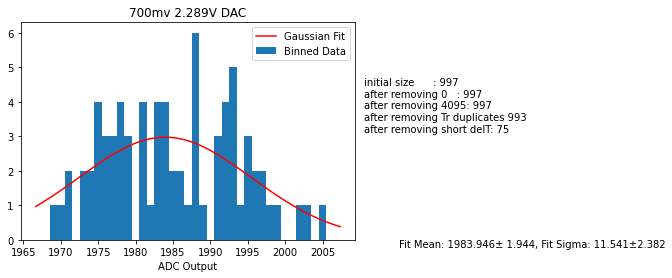

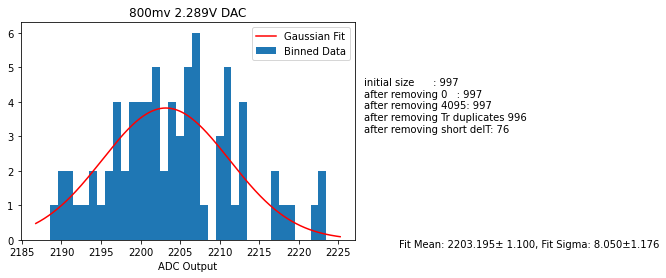

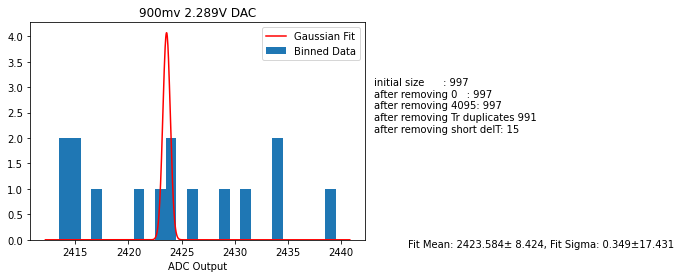

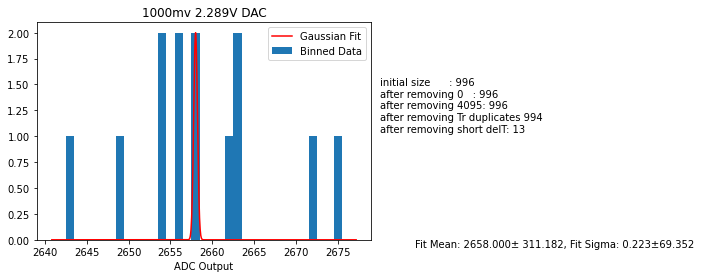

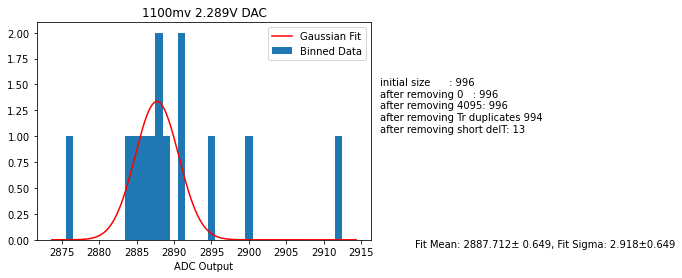

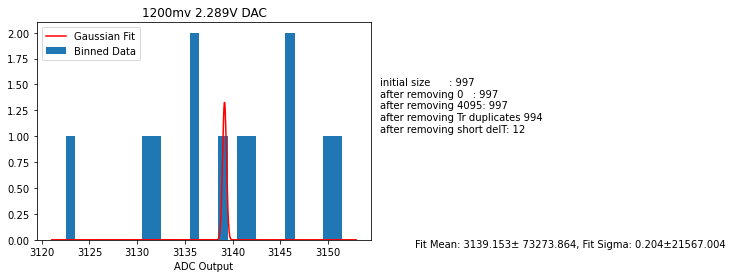

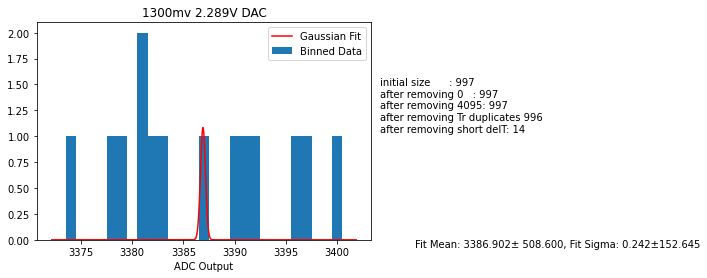

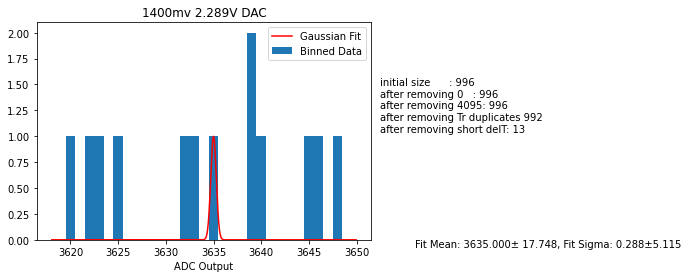

[[6, 271.1632897857714, 2.553410246281726], [8, 276.3753949721874, 2.4766750593197706], [10, 280.7815259982112, 2.3931299482355253], [20, 305.31223974521794, 2.4605723824201484], [30, 329.5643042430902, 2.3579808926521557], [40, 355.8972110360249, 2.562184957729345], [50, 380.71266669452746, 2.456094800337791], [60, 406.06459171041223, 2.5600064450741478], [80, 457.7125909313323, 2.549411756447682], [100, 508.27118002244947, 2.3877951746291157], [150, 637.6763689144894, 9.6335178614232], [200, 769.6097310407237, 7.683405527788951], [250, 902.6493122130686, 9.469091156534944], [300, 1035.6201664146636, 7.242811084869939], [350, 1165.9729583945505, 8.97017784748448], [400, 1287.6208202472194, 9.330167875555192], [450, 1410.0514720822496, 6.646982528563882], [500, 1530.6772347593046, 7.9420404222037515], [600, 1759.5895331855556, 6.361726167195741], [700, 1983.9460886104328, 11.540887976833366], [800, 2203.1952767228713, 8.050138134635743], [900, 2423.5842252509356, 0.34859128830903185], 

In [7]:

fittedVals = []

for voltageDAC in dfs:
    dfs[voltageDAC] = dfs[voltageDAC].iloc[2:]
    plttitle = voltageDAC[:-2]
    
    df = dfs[voltageDAC]
    lenPreZero = len(df)
    cut0 = df[df["ADC"] > 0]
    lenPre4095 = len(cut0)
    cut1 = cut0[cut0["ADC"] < 4095] 
    lenPreDupes = len(cut1)
    cut2 = cut1.drop_duplicates(subset=['Tr [ns]'], keep='first')
    lenPredelTmin = len(cut2)
    cut3 = cut2[cut2["delT [ns]"] > 4]
    cut4 = cut3[cut3["ADC"] > 0] 
    #df_cut = cut4[cut4["delT [ns]"] > 3*(4*(int(voltageDAC[:-2])/1600))]
    

    if int(voltageDAC[:-2]) >=100:
        cut5 = cut4[cut4["ADC"] > 400]
    else:
        cut5 = cut4

    df_cut = cut5
    lenFin = len(df_cut)   

    #print(df_cut[df_cut["ADC"] < 400].head(50)) 

    #print(df_cut["ADC"].mean())

    if len(df_cut) > 0:
        w = 1
        binval, binlims,patches = plt.hist(df_cut["ADC"],bins=np.arange(df_cut["ADC"].min()-0.5, df_cut["ADC"].max() + 0.5 + w, w),label = "Binned Data")
        
        plt.title(voltageDAC)
    
        binx = [] # get the bin mid points for fitting
        for i in range(len(binlims)-1):
            binx.append((binlims[i] + binlims[i+1]) /2)
    
        # fit gaussian to histogram
        popt,pcov = curve_fit(gaussFunc,binx,binval,p0=[1000,df_cut["ADC"].mean(),5],bounds=[[0,0,0.1], [100000,10000,100]])
        
        xlims = plt.xlim()
        xrange = np.linspace(xlims[0],xlims[1],1000)
        yvals = gaussFunc(xrange,popt[0],popt[1],popt[2])
    
        fittedVals.append([int(plttitle),popt[1],popt[2]])
        
        plt.plot(xrange,yvals,'r-',label="Gaussian Fit")
        plt.title("{}mv 2.289V DAC".format(plttitle))
        plt.xlabel("ADC Output")
        #plt.figtext(1.0,0.2,df_cut["ADC"].describe()[0:2])
        plt.figtext(1.0,0.1,"Fit Mean: {0:.3f}± {1:.3f}, Fit Sigma: {2:.3f}±{3:.3f}".format(popt[1],np.sqrt(pcov[1][1]),popt[2],np.sqrt(pcov[2][2])))
        plt.legend()
        plt.figtext(0.92,0.5,"initial size      : {0}\nafter removing 0   : {1} \nafter removing 4095: {2}\nafter removing Tr duplicates {3}\nafter removing short delT: {4}".format(lenPreZero,lenPre4095,lenPreDupes,lenPredelTmin,lenFin))
        plt.show()

    else:
        print("none left after cuts for {}".format(voltageDAC))

print(fittedVals)

#plt.yscale('log')

6
8
10
20
30
40
50
60
80
100
150
200
250
300
350


<Figure size 432x288 with 0 Axes>

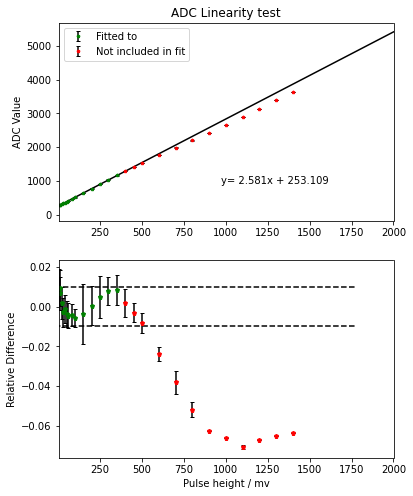

In [14]:

plt.clf()

fig, axs = plt.subplots(2,1,figsize=(6,8))
axs[0].set_title("ADC Linearity test")

xpos = []
ypos = []
err = []

xpos_unfit = []
ypos_unfit = []
err_unfit = []

for i in fittedVals:
    if i[0] < 400:
        print(i[0])
        xpos.append(i[0])
        ypos.append(i[1])
        err.append(i[2])
    else:
        xpos_unfit.append(i[0])
        ypos_unfit.append(i[1])
        err_unfit.append(i[2])
    

#pedestal subtract

ypos_pedsub = np.array(ypos) # - 259.440
ypos_unfit_pedsub = np.array(ypos_unfit) # - 259.440

axs[0].errorbar(xpos,ypos_pedsub,err,marker = "p",markersize = 3,capsize=2,color="k",ls = 'none',mfc="green",mec="green",label = "Fitted to")
axs[0].errorbar(xpos_unfit,ypos_unfit_pedsub,err_unfit,marker = "p",markersize = 3,capsize=2,color="k",ls = 'none',mfc="red",mec="red", label = "Not included in fit")
axs[0].legend()
xlims_linplot = axs[0].get_xlim()
#axs[0].set_xlim(xlims_linplot[0],xlims_linplot[1])

def linFunc(x,p1,p2):
    y = p1*x + p2
    return y

popt_linearity,pcov_linearity = curve_fit(linFunc,xpos,ypos,sigma = err)

xSamples = np.linspace(xlims_linplot[0],2000,1000)
axs[0].plot(xSamples,linFunc(xSamples,popt_linearity[0],popt_linearity[1]),"k-") #-pedestal
axs[0].set_ylabel("ADC Value")
relativeDiff = []

for i in range(len(xpos)):
    
    relativeDiff.append((ypos[i]-linFunc(xpos[i],popt_linearity[0],popt_linearity[1]))/ypos[i])

relativeDiff_unfit = []
    
for i in range(len(xpos_unfit)):
    relativeDiff_unfit.append((ypos_unfit[i]-linFunc(xpos_unfit[i],popt_linearity[0],popt_linearity[1]))/ypos_unfit[i])
    
relDiffError = np.array(err)/(np.array(ypos))
relDiffErr_unfit = np.array(err_unfit)/(np.array(ypos_unfit))
#plt.plot(xpos,relativeDiff,"ro")
axs[1].plot([xlims_linplot[0]-100,xlims_linplot[1]+300],[0.01,0.01],"k--")
axs[1].plot([xlims_linplot[0]-100,xlims_linplot[1]+300],[-0.01,-0.01],"k--")
axs[1].errorbar(xpos,relativeDiff,relDiffError,marker = "p",markersize = 5,ls = 'none',mfc="green",mec="green",capsize=2,solid_capstyle="butt",color='k')
axs[1].errorbar(xpos_unfit,relativeDiff_unfit,relDiffErr_unfit,marker = "p",markersize = 5,ls = 'none',mfc="red",mec="red",capsize=2,solid_capstyle="butt",color='k')
#axs[1].set_xlim(xlims_linplot[0],xlims_linplot[1])
axs[1].set_xlabel("Pulse height / mv")
axs[1].set_ylabel("Relative Difference")
#axs[0].set_xscale('log')
#axs[0].set_yscale('log')
#axs[1].set_xscale('log')
axs[0].set_xlim(3,2000)
axs[1].set_xlim(3,2000)

#plt.figtext(0.5,0.6,"y= {0:.3f}x + {1:.3f}\n * plotted with \n    pedestal subtracted".format(popt_linearity[0],popt_linearity[1]))
plt.figtext(0.5,0.6,"y= {0:.3f}x + {1:.3f}".format(popt_linearity[0],popt_linearity[1]))

plt.show()

6


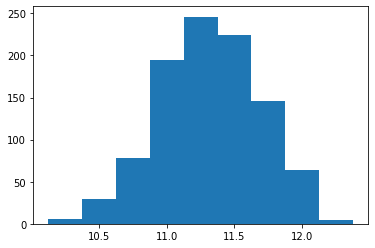

8


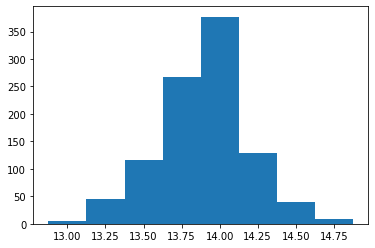

10


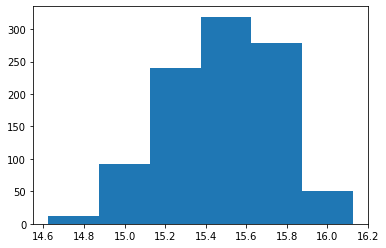

20


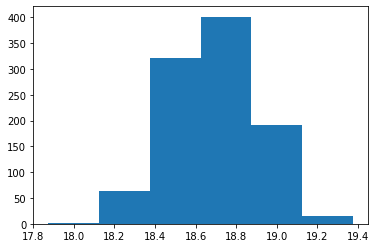

30


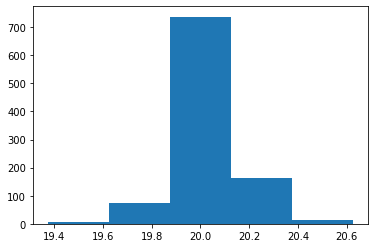

40


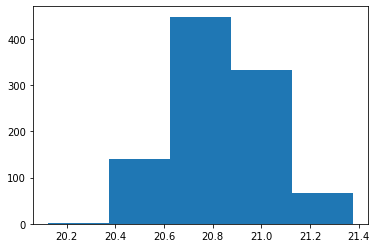

50


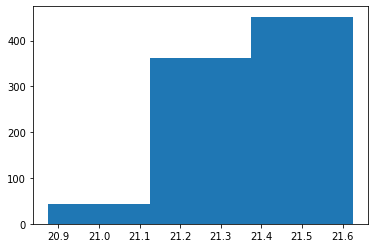

60


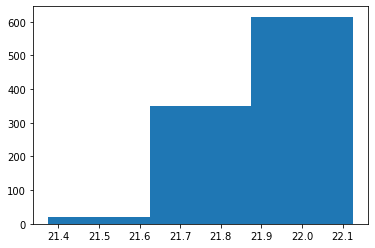

80


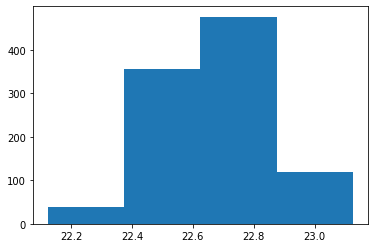

100


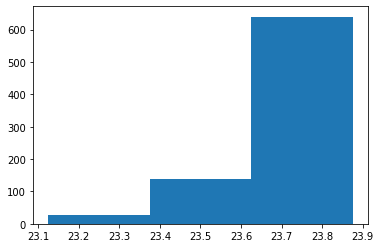

150


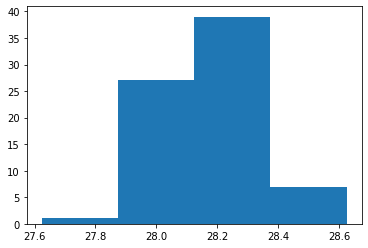

200


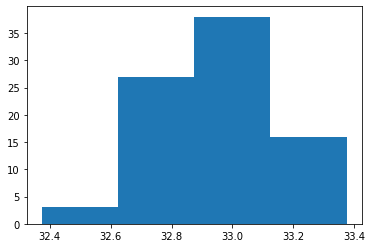

250


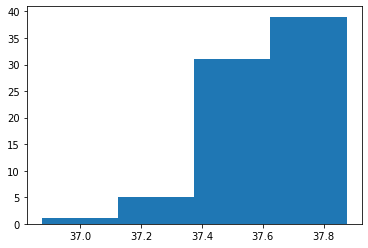

300


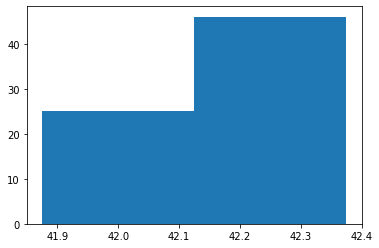

350


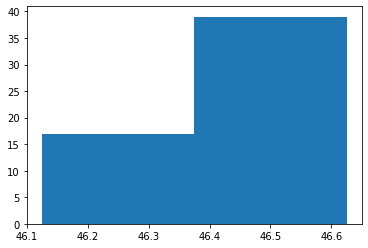

400


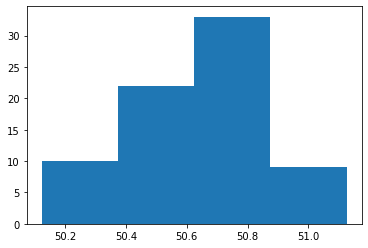

450


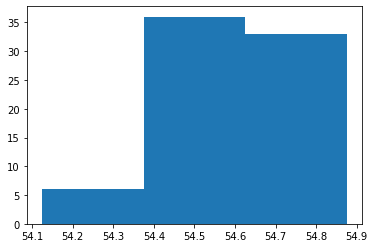

500


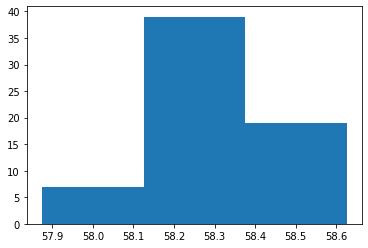

600


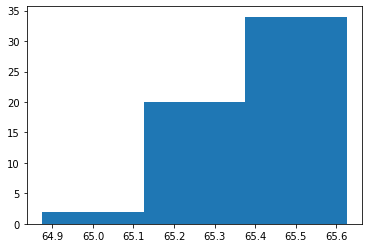

700


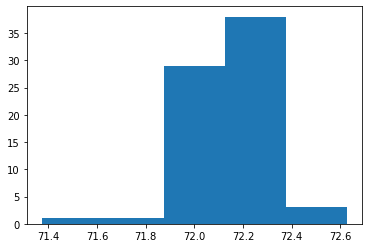

800


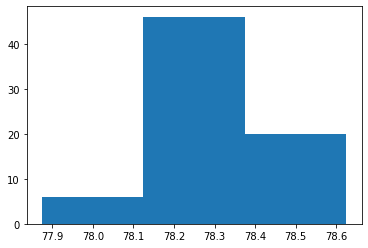

900


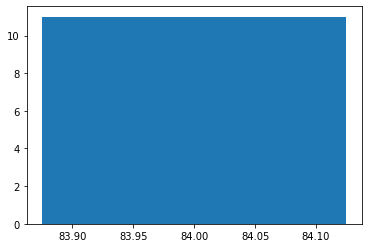

1000


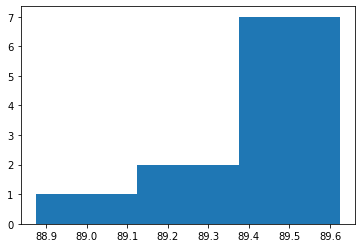

1100


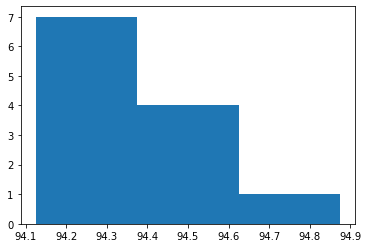

1200
1200mv


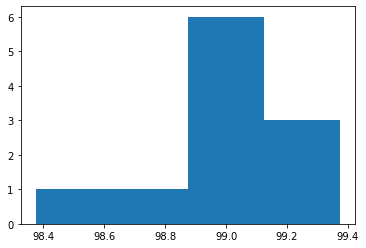

1300


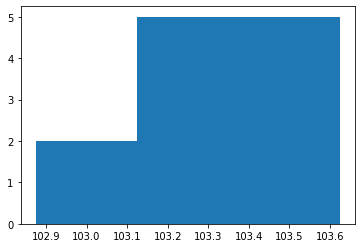

1400


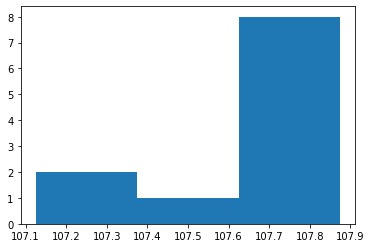

[6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400] 
 [11.319597989949749, 13.896316851664984, 15.481639839034205, 18.69321608040201, 20.02791750503018, 20.83434038267875, 21.421859296482413, 21.90332326283988, 22.672535211267604, 23.749748490945674, 28.183333333333334, 32.96220930232558, 37.625, 42.19620253164557, 46.50666666666667, 50.66233766233766, 54.60064935064935, 58.33450704225352, 65.45588235294117, 72.16666666666667, 78.32236842105263, 84.06666666666666, 89.45833333333333, 94.42307692307692, 99.04166666666667, 103.375, 107.6923076923077] 
 [0.38110270904973925, 0.3044850869755069, 0.2766098663997764, 0.22409376752281393, 0.14026944735200012, 0.20637274683383103, 0.1906044085134869, 0.13505536959140935, 0.185814153294515, 0.16546628284349268, 0.17597860230286086, 0.21184567725415648, 0.18657472117700855, 0.15333308637774165, 0.17424224619867695, 0.24590807067027964, 0.1684865890519547, 0.193389235425

Text(0, 0.5, 'Time over threshold / ns')

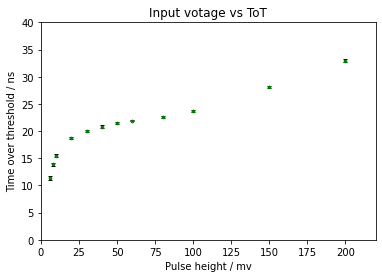

In [9]:

nxpos = []
tots = []
totserr = []        
        
for i in dfs:

        dfs[i] = dfs[i].iloc[2:]
        plttitle = i[:-2]
        df = dfs[i]
        print(plttitle)
        cut0 = df[df["ADC"] > 0]
        lenPre4095 = len(cut0)
        cut1 = cut0[cut0["ADC"] < 4095] 
        lenPreDupes = len(cut1)
        df_cut = cut1.drop_duplicates(subset=['Tr [ns]'], keep='first')
        lenPredelTmin = len(df_cut)
        df_cut = df_cut[df_cut["delT [ns]"] > 4]
        
        if int(i[:-2]) == 1200:
            print("1200mv")
            df_cut = df_cut[(df_cut["delT [ns]"] > 95) & (df_cut["delT [ns]"] < 125)] 
        elif int(i[:-2]) >= 60:
            df_cut = df_cut[(df_cut["delT [ns]"] > 20) & (df_cut["delT [ns]"] < 200)]
        else:
            df_cut = df_cut

        lenFin = len(df_cut)   
        plt.hist(df_cut["delT [ns]"],bins=np.arange(df_cut["delT [ns]"].min()-0.125,df_cut["delT [ns]"].max() + 0.125,0.25))
        plt.show()
        nxpos.append(int(i[:-2]))
        tots.append(df_cut["delT [ns]"].mean())
        totserr.append(df_cut["delT [ns]"].std())
        #print("tot: {}±{}".format(tots,toterr))

print(nxpos,"\n",tots,"\n",totserr)

plt.errorbar(nxpos,tots,totserr,marker = "p",markersize = 3,capsize=2,color="k",ls = 'none',mfc="green",mec="green")
plt.xlim(0,220)
plt.ylim(0,40)
plt.title("Input votage vs ToT")
plt.xlabel("Pulse height / mv")
plt.ylabel("Time over threshold / ns")

Text(0.5, 0, 'delT / ns')

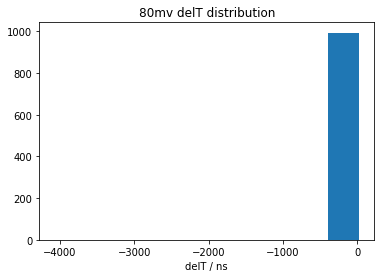

In [10]:
plt.hist(dfs["80mv"]["delT [ns]"])
plt.title("80mv delT distribution")
plt.xlabel("delT / ns")

33.5
32.5
4.0
782
761
21.0


Text(0, 0.5, 'delT / ns')

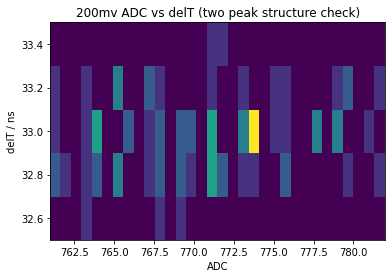

In [11]:
dfs["200mv"].head(50)
df = dfs["200mv"]

df = df[df["ADC"] > 0]
df = df[df["ADC"] < 4095]
df = df.drop_duplicates(subset=['Tr [ns]'], keep='first')
df = df[df["delT [ns]"] > 20]

print(df["delT [ns]"].max())
print(df["delT [ns]"].min())
print((df["delT [ns]"].max()-df["delT [ns]"].min())/0.25)
print(df["ADC"].max())
print(df["ADC"].min())
print((df["ADC"].max()-df["ADC"].min())/1)
plt.hist2d(df["ADC"],df["delT [ns]"],bins = [32,5])
plt.title("200mv ADC vs delT (two peak structure check)")
plt.xlabel("ADC")
plt.ylabel("delT / ns")

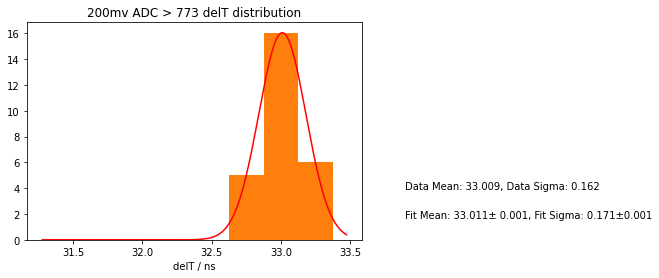

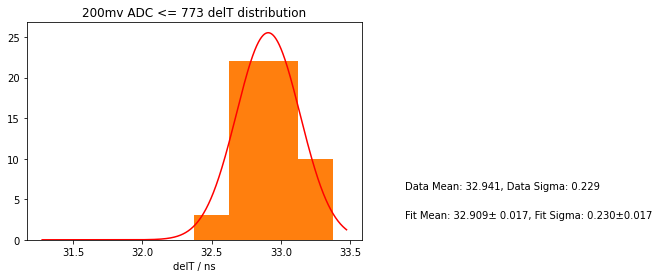

In [12]:
hi_adc = df[df["ADC"] > 773]
lo_adc = df[df["ADC"] <= 773]

plt.hist(hi_adc["delT [ns]"],bins = np.arange(31.5-0.125, 33.5 + 0.125, 0.25))
plt.title("200mv ADC > 773 delT distribution")
plt.xlabel("delT / ns")
binval, binlims,patches = plt.hist(hi_adc["delT [ns]"],bins=np.arange(31.5-0.125, 33.5 + 0.125, 0.25),label = "Binned Data")
binx = [] # get the bin mid points for fitting
for i in range(len(binlims)-1):
    binx.append((binlims[i] + binlims[i+1]) /2)
popt,pcov = curve_fit(gaussFunc,binx,binval,p0=[100,hi_adc["delT [ns]"].mean(),1],bounds=[[0,hi_adc["delT [ns]"].mean()-hi_adc["delT [ns]"].std(),0.1],[100000,hi_adc["delT [ns]"].mean()+hi_adc["delT [ns]"].std(),100]] )

xlims = plt.xlim()
xrange = np.linspace(xlims[0],xlims[1],1000)
yvals = gaussFunc(xrange,popt[0],popt[1],popt[2])

plt.plot(xrange,yvals,'r-',label="Gaussian Fit")
plt.figtext(1.0,0.3,"Data Mean: {0:.3f}, Data Sigma: {1:.3f}".format(hi_adc["delT [ns]"].mean(),hi_adc["delT [ns]"].std()))
plt.figtext(1.0,0.2,"Fit Mean: {0:.3f}± {1:.3f}, Fit Sigma: {2:.3f}±{3:.3f}".format(popt[1],np.sqrt(pcov[1][1]),popt[2],np.sqrt(pcov[2][2])))
plt.show()



plt.hist(lo_adc["delT [ns]"],bins = np.arange(31.5-0.125, 33.5 + 0.125, 0.25))
plt.title("200mv ADC <= 773 delT distribution")
plt.xlabel("delT / ns")
binval, binlims,patches = plt.hist(lo_adc["delT [ns]"],bins=np.arange(31.5-0.125, 33.5 + 0.125, 0.25),label = "Binned Data")
binx = [] # get the bin mid points for fitting
for i in range(len(binlims)-1):
    binx.append((binlims[i] + binlims[i+1]) /2)
popt,pcov = curve_fit(gaussFunc,binx,binval,p0=[100,hi_adc["delT [ns]"].mean(),1],bounds=[[0,hi_adc["delT [ns]"].mean()-hi_adc["delT [ns]"].std(),0.1],[100000,hi_adc["delT [ns]"].mean()+hi_adc["delT [ns]"].std(),100]])

xlims = plt.xlim()
xrange = np.linspace(xlims[0],xlims[1],1000)
yvals = gaussFunc(xrange,popt[0],popt[1],popt[2])

plt.plot(xrange,yvals,'r-',label="Gaussian Fit")
plt.figtext(1.0,0.3,"Data Mean: {0:.3f}, Data Sigma: {1:.3f}".format(lo_adc["delT [ns]"].mean(),lo_adc["delT [ns]"].std()))
plt.figtext(1.0,0.2,"Fit Mean: {0:.3f}± {1:.3f}, Fit Sigma: {2:.3f}±{3:.3f}".format(popt[1],np.sqrt(pcov[1][1]),popt[2],np.sqrt(pcov[2][2])))
plt.show()


